# Activation Functions made generic

In [1]:
import tensorflow as tf
from tensorflow.keras.activations import relu,tanh,selu,sigmoid,softmax,softplus,softsign,elu
from tensorflow.keras.losses import CategoricalCrossentropy, BinaryCrossentropy
from tensorflow.keras.optimizers import SGD

from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import numpy as np
from matplotlib import pyplot as plt

## Generic class to handle any data

In [2]:
class DynamicActivationFunction:
  """
  The class dynamically creates a single hidden layer and output layer of 
  desired units and trains any data with best activation function.
  """
  def __init__(self,hidden_units, output_units):
    self.hidden_units = hidden_units
    self.output_units = output_units
    self.activations = {
      'relu': relu,
      'tan_h': tanh,
      'selu': selu,
      'softmax': softmax,
      'softplus': softplus,
      'softsign': softsign,
      'elu': elu
      }
    self.initializer = tf.random.normal
    self.loss_fn = CategoricalCrossentropy(from_logits=True)
    self.optimizer = SGD(learning_rate=1e-3)
    self.history = {
        'train_loss':[],
        'test_loss':[],
        'train_acc':[],
        'test_acc':[]
    }
    self.final_activation = None


  def create_model(self,X_test):
    """
    Neural Network creation code
    """
    self.hidden_weights = tf.Variable(self.initializer(shape=[X_test.shape[1],self.hidden_units], dtype=tf.float32),name="hidden layer wights")
    self.hidden_bias = tf.Variable(tf.zeros(shape=[self.hidden_units], dtype=tf.float32),name="hidden layer bias")

    self.out_weights = tf.Variable(self.initializer(shape=[self.hidden_units,self.output_units], dtype=tf.float32),name="output layer wights")
    self.out_bias = tf.Variable(tf.zeros(shape=[self.output_units], dtype=tf.float32),name="output layer bias")

    self.trainable_params = {
        'hidden_weights': self.hidden_weights,
        'hidden_bias': self.hidden_bias,
        'out_weights': self.out_weights,
        'out_bias': self.out_bias
    }
  
  def forward_pass(self, X, activation="relu"):
    """
    Forward propogation code
    """
    hidden_output = X @ self.trainable_params['hidden_weights'] + self.trainable_params['hidden_bias']
    
    hidden_output = self.activations[activation](hidden_output)

    y_pred = hidden_output @ self.trainable_params['out_weights'] + self.trainable_params['out_bias']
    y_pred = self.activations['softmax'](y_pred)
    return y_pred

  def fit(self,train_ds,test_ds, epochs, steps_per_epoch, combination_activations=['relu','elu','tan_h','selu','softplus','softsign']):
    X_test,y_test = next(test_ds)
    self.create_model(X_test)

    # using 1/5 th of epochs to find best activation
    experimental_epochs = epochs//5
    experiment = True

    final_activation = None
    epoch_major_activation = []

    for epoch in range(epochs): #iterator over epochs
      X_test,y_test = next(test_ds)
      X_test = tf.convert_to_tensor(X_test,dtype=tf.float32)
      y_test = tf.convert_to_tensor(y_test,dtype=tf.float32)
      per_epoch_activations = []
      for steps in range(steps_per_epoch): # iterate each step of epoch
        X_train,y_train = next(train_ds)
        X_train = tf.convert_to_tensor(X_train,dtype=tf.float32)
        y_train = tf.convert_to_tensor(y_train,dtype=tf.float32)

        with tf.GradientTape(persistent=True) as tape:
          tape.watch(X_train)
          if experiment:
            losses = []
            # Find best activation by finding which produces minimum loss
            for activation in combination_activations:
              y_pred = self.forward_pass(X_train, activation)
              loss = self.loss_fn(y_train,y_pred)
              losses.append(loss)
            indx = np.argmin(np.array(losses))
            loss = tf.reduce_mean(losses[indx])
            y_pred = self.forward_pass(X_train, combination_activations[indx])
            # Calculating accuracy
            y_pred = tf.one_hot(np.argmax(y_pred, axis=1),depth=self.output_units)
            train_acc = accuracy_score(y_train,y_pred.numpy())
            per_epoch_activations.append(combination_activations[indx])
          else:
            y_pred = self.forward_pass(X_train, final_activation)
            loss = self.loss_fn(y_train,y_pred)
            loss = tf.reduce_mean(loss)
            y_pred = tf.one_hot(np.argmax(y_pred, axis=1),depth=self.output_units)
            train_acc = accuracy_score(y_train,y_pred.numpy())
        # back propogation
        params = tape.watched_variables()
        grads = tape.gradient(loss, params)
        self.optimizer.apply_gradients(zip(grads, params))

      # To find test accuracy same code is repeated on test data
      if experiment:
        high_used_activation_epoch = max(set(per_epoch_activations), key=per_epoch_activations.count)
        epoch_major_activation.append(high_used_activation_epoch)
        y_pred = self.forward_pass(X_test, high_used_activation_epoch)
        test_loss = self.loss_fn(y_test,y_pred)
        test_loss = tf.reduce_mean(test_loss)

        y_pred = tf.one_hot(np.argmax(y_pred, axis=1),depth=self.output_units)
        test_acc = accuracy_score(y_test,y_pred.numpy())
        print(f"epoch: {epoch+1}/{epochs} loss: {np.round([loss.numpy()],4)} accuracy: {np.round([train_acc],4)} activation: [{high_used_activation_epoch}] loss: {np.round([test_loss.numpy()],4)} accuracy: {np.round([test_acc],4)} ")
      else:
        y_pred = self.forward_pass(X_test, final_activation)
        test_loss = self.loss_fn(y_test,y_pred)
        test_loss = tf.reduce_mean(test_loss)
        y_pred = tf.one_hot(np.argmax(y_pred, axis=1),depth=self.output_units)
        test_acc = accuracy_score(y_test,y_pred.numpy())
        print(f"epoch: {epoch+1}/{epochs} loss: {np.round([loss.numpy()],4)} accuracy: {np.round([train_acc],4)} activation: [{final_activation}] loss: {np.round([test_loss.numpy()],4)} accuracy: {np.round([test_acc],4)} ")
      
      # maintaining trach of losses and accuracy over iterations
      self.history['train_loss'].append(loss.numpy())
      self.history['test_loss'].append(test_loss.numpy())

      self.history['train_acc'].append(train_acc)
      self.history['test_acc'].append(test_acc)

      # block to stop experimenting o
      if epoch+1 == experimental_epochs:
        experiment = False
        final_activation = max(set(epoch_major_activation), key=epoch_major_activation.count)
        print("*****************************************************************************************************************")
        print(f"************* \t Fianlized Activation: {final_activation} \t****************")
        print("*****************************************************************************************************************")
    self.final_activation = final_activation
    return self.final_activation

  def predict(self,X_test):
    """
    predict based on trained params
    """
    X_test = tf.convert_to_tensor(X_test,dtype=tf.float32)
    y_pred = self.forward_pass(X_test, self.final_activation)
    test_loss = self.loss_fn(y_test,y_pred)
    test_loss = tf.reduce_mean(test_loss)
    y_pred = tf.one_hot(np.argmax(y_pred, axis=1),depth=self.output_units)
    return y_pred

## Iris Dataset

In [3]:
from sklearn.datasets import load_iris

data = load_iris()
X = data['data']
y = data['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

y_train = tf.one_hot(y_train,depth=3)
y_test = tf.one_hot(y_test,depth=3)

train_ds = tf.data.Dataset.from_tensor_slices((X_train,y_train)).batch(16, drop_remainder=True).repeat().as_numpy_iterator()

test_ds = tf.data.Dataset.from_tensor_slices((X_test,y_test)).batch(16, drop_remainder=True).repeat().as_numpy_iterator()

df = DynamicActivationFunction(250,3)
final_activation = df.fit(train_ds,test_ds,250,50)

print(f"************* \t Fianlized Activation: {final_activation} \t****************")

epoch: 1/250 loss: [2.6856] accuracy: [0.625] activation: [softsign] loss: [0.5656] accuracy: [0.875] 
epoch: 2/250 loss: [0.9009] accuracy: [0.875] activation: [softsign] loss: [0.5194] accuracy: [0.875] 
epoch: 3/250 loss: [0.0687] accuracy: [1.] activation: [softsign] loss: [0.4611] accuracy: [0.875] 
epoch: 4/250 loss: [1.7793] accuracy: [0.6875] activation: [softsign] loss: [0.401] accuracy: [0.875] 
epoch: 5/250 loss: [0.382] accuracy: [0.875] activation: [relu] loss: [1.8517] accuracy: [0.75] 
epoch: 6/250 loss: [0.4006] accuracy: [0.875] activation: [softsign] loss: [0.2978] accuracy: [0.9375] 
epoch: 7/250 loss: [0.7175] accuracy: [0.6875] activation: [softsign] loss: [0.2626] accuracy: [0.9375] 
epoch: 8/250 loss: [1.3529] accuracy: [0.6875] activation: [softsign] loss: [0.2286] accuracy: [0.9375] 
epoch: 9/250 loss: [0.6503] accuracy: [0.9375] activation: [relu] loss: [1.5746] accuracy: [0.75] 
epoch: 10/250 loss: [0.0729] accuracy: [1.] activation: [relu] loss: [1.5078] acc

In [4]:
y_pred = df.predict(X_test)
test_acc = accuracy_score(y_test,y_pred.numpy())
score = f1_score(y_test, y_pred, average=None)

print(f"Test accuracy:{test_acc}, F1 Score:{score}")

Test accuracy:1.0, F1 Score:[1. 1. 1.]


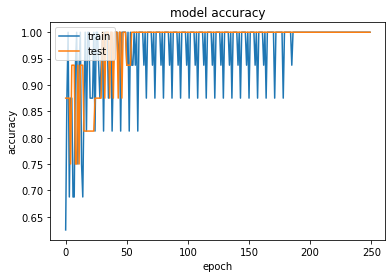

In [5]:
plt.plot(df.history['train_acc'])
plt.plot(df.history['test_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

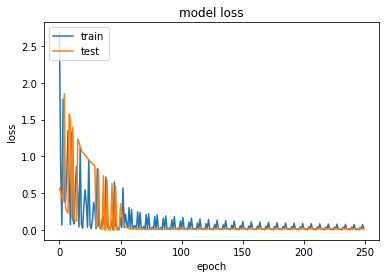

In [6]:
plt.plot(df.history['train_loss'])
plt.plot(df.history['test_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## MNIST Dataset

In [7]:
from tensorflow.keras.datasets.mnist import load_data
(X_train,y_train), (X_test, y_test) = load_data()

X_train = X_train/255
X_test = X_test/255

X_train = X_train.reshape(X_train.shape[0],X_train.shape[1]*X_train.shape[2])
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1]*X_test.shape[2])

y_train = tf.one_hot(y_train,depth=10)
y_test = tf.one_hot(y_test,depth=10)

train_ds = tf.data.Dataset.from_tensor_slices((X_train,y_train)).batch(32, drop_remainder=True).repeat().as_numpy_iterator()

test_ds = tf.data.Dataset.from_tensor_slices((X_test,y_test)).batch(32, drop_remainder=True).repeat().as_numpy_iterator()

df = DynamicActivationFunction(1500,10)
final_activation = df.fit(train_ds,test_ds,350,100)
print(f"************* \t Fianlized Activation: {final_activation} \t****************")

epoch: 1/350 loss: [34.0468] accuracy: [0.2812] activation: [softsign] loss: [33.178] accuracy: [0.2188] 
epoch: 2/350 loss: [34.6118] accuracy: [0.1562] activation: [softsign] loss: [31.2272] accuracy: [0.2188] 
epoch: 3/350 loss: [35.5264] accuracy: [0.0938] activation: [softsign] loss: [31.9717] accuracy: [0.1875] 
epoch: 4/350 loss: [22.6239] accuracy: [0.3438] activation: [softsign] loss: [25.4716] accuracy: [0.2188] 
epoch: 5/350 loss: [27.7088] accuracy: [0.125] activation: [softsign] loss: [26.5791] accuracy: [0.125] 
epoch: 6/350 loss: [22.4647] accuracy: [0.1562] activation: [softsign] loss: [20.9261] accuracy: [0.2812] 
epoch: 7/350 loss: [27.4937] accuracy: [0.1875] activation: [softsign] loss: [19.3981] accuracy: [0.2812] 
epoch: 8/350 loss: [21.0404] accuracy: [0.4062] activation: [softsign] loss: [17.5625] accuracy: [0.375] 
epoch: 9/350 loss: [24.9017] accuracy: [0.1875] activation: [softsign] loss: [17.9413] accuracy: [0.375] 
epoch: 10/350 loss: [22.4959] accuracy: [0

In [8]:
y_pred = df.predict(X_test)
test_acc = accuracy_score(y_test,y_pred.numpy())
score = f1_score(y_test, y_pred, average=None)

print(f"Test accuracy:{test_acc}, F1 Score:{score}")

Test accuracy:0.851, F1 Score:[0.91440287 0.9499561  0.84515195 0.82364532 0.83923155 0.78587699
 0.88220031 0.87292278 0.77986782 0.79638917]


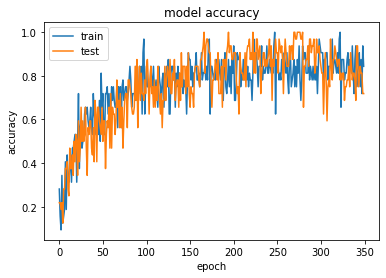

In [9]:
plt.plot(df.history['train_acc'])
plt.plot(df.history['test_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

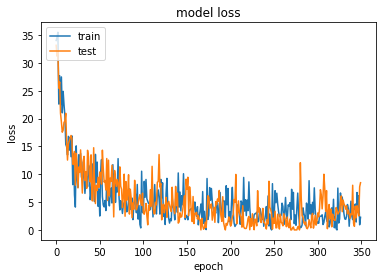

In [10]:
plt.plot(df.history['train_loss'])
plt.plot(df.history['test_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Bank Note

In [11]:
import pandas as pd
df = pd.read_csv('https://raw.githubusercontent.com/AbhiRoy96/Banknote-Authentication-UCI-Dataset/master/bank_notes.csv')
X = df.iloc[:, 0:-1]
y = df.iloc[:, -1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

y_train = tf.one_hot(y_train,depth=2)
y_test = tf.one_hot(y_test,depth=2)

train_ds = tf.data.Dataset.from_tensor_slices((X_train,y_train)).batch(32, drop_remainder=True).repeat().as_numpy_iterator()

test_ds = tf.data.Dataset.from_tensor_slices((X_test,y_test)).batch(32, drop_remainder=True).repeat().as_numpy_iterator()

df = DynamicActivationFunction(150,2)
final_activation = df.fit(train_ds,test_ds,150,40)
print(f"************* \t Fianlized Activation: {final_activation} \t****************")

epoch: 1/150 loss: [1.5771] accuracy: [0.6875] activation: [softsign] loss: [3.4811] accuracy: [0.5625] 
epoch: 2/150 loss: [2.5465] accuracy: [0.5312] activation: [softsign] loss: [2.0798] accuracy: [0.6875] 
epoch: 3/150 loss: [0.8117] accuracy: [0.8125] activation: [softsign] loss: [1.44] accuracy: [0.7188] 
epoch: 4/150 loss: [1.1597] accuracy: [0.6875] activation: [softsign] loss: [2.0689] accuracy: [0.5312] 
epoch: 5/150 loss: [0.9661] accuracy: [0.6562] activation: [softsign] loss: [0.2023] accuracy: [0.9375] 
epoch: 6/150 loss: [0.6039] accuracy: [0.7812] activation: [softsign] loss: [0.9422] accuracy: [0.6562] 
epoch: 7/150 loss: [0.5533] accuracy: [0.75] activation: [softsign] loss: [0.3959] accuracy: [0.8438] 
epoch: 8/150 loss: [0.3956] accuracy: [0.8125] activation: [softsign] loss: [0.3569] accuracy: [0.8438] 
epoch: 9/150 loss: [0.3082] accuracy: [0.875] activation: [softsign] loss: [0.3066] accuracy: [0.8125] 
epoch: 10/150 loss: [0.3972] accuracy: [0.8438] activation: 

In [12]:
y_pred = df.predict(X_test)
test_acc = accuracy_score(y_test,y_pred.numpy())
score = f1_score(y_test, y_pred, average=None)

print(f"Test accuracy:{test_acc}, F1 Score:{score}")

Test accuracy:0.9818181818181818, F1 Score:[0.98327759 0.98007968]


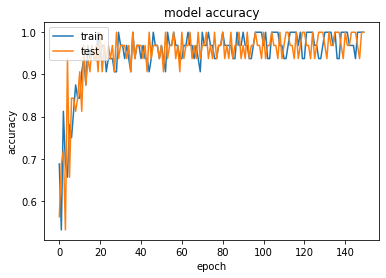

In [13]:
plt.plot(df.history['train_acc'])
plt.plot(df.history['test_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

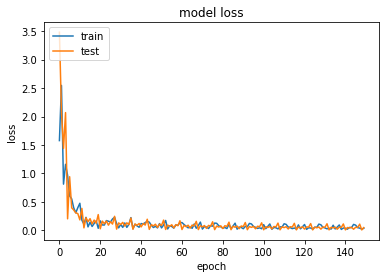

In [14]:
plt.plot(df.history['train_loss'])
plt.plot(df.history['test_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Wisconsin Breast Cancer

In [15]:
df = pd.read_csv('https://raw.githubusercontent.com/jeffheaton/aifh/master/vol1/python-examples/datasets/breast-cancer-wisconsin.csv')
df["class"].replace({2:0,4:1},inplace=True)
df["bare_nucleoli"].replace({'?':np.NaN},inplace=True)
df["bare_nucleoli"] = pd.to_numeric(df["bare_nucleoli"])
df["bare_nucleoli"].fillna(df["bare_nucleoli"].mean(),inplace=True)


X = df.iloc[:, 1:-1]
y = df.iloc[:, -1]

X = X.values.astype(np.float32)
y = y.values.astype(np.float32)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

y_train = tf.one_hot(y_train,depth=2)
y_test = tf.one_hot(y_test,depth=2)

train_ds = tf.data.Dataset.from_tensor_slices((X_train,y_train)).batch(32, drop_remainder=True).repeat().as_numpy_iterator()

test_ds = tf.data.Dataset.from_tensor_slices((X_test,y_test)).batch(32, drop_remainder=True).repeat().as_numpy_iterator()

df = DynamicActivationFunction(500,2)
final_acivation = df.fit(train_ds,test_ds,250,50)
print(f"************* \t Fianlized Activation: {final_activation} \t****************")

epoch: 1/250 loss: [0.6621] accuracy: [0.9375] activation: [softsign] loss: [1.1673] accuracy: [0.9062] 
epoch: 2/250 loss: [0.0117] accuracy: [1.] activation: [softsign] loss: [0.0007] accuracy: [1.] 
epoch: 3/250 loss: [0.6111] accuracy: [0.9062] activation: [softsign] loss: [2.0924] accuracy: [0.8438] 
epoch: 4/250 loss: [0.0004] accuracy: [1.] activation: [softsign] loss: [0.7483] accuracy: [0.875] 
epoch: 5/250 loss: [1.0355] accuracy: [0.9375] activation: [softsign] loss: [1.0919] accuracy: [0.9062] 
epoch: 6/250 loss: [0.0012] accuracy: [1.] activation: [softsign] loss: [0.0007] accuracy: [1.] 
epoch: 7/250 loss: [0.6367] accuracy: [0.9688] activation: [softsign] loss: [1.963] accuracy: [0.8438] 
epoch: 8/250 loss: [0.0622] accuracy: [0.9688] activation: [softsign] loss: [0.6042] accuracy: [0.9062] 
epoch: 9/250 loss: [0.3478] accuracy: [0.9688] activation: [softsign] loss: [1.0283] accuracy: [0.9062] 
epoch: 10/250 loss: [0.4914] accuracy: [0.9375] activation: [softsign] loss: 

In [16]:
y_pred = df.predict(X_test)
test_acc = accuracy_score(y_test,y_pred.numpy())
score = f1_score(y_test, y_pred, average=None)

print(f"Test accuracy:{test_acc}, F1 Score:{score}")

Test accuracy:0.9285714285714286, F1 Score:[0.94949495 0.87804878]


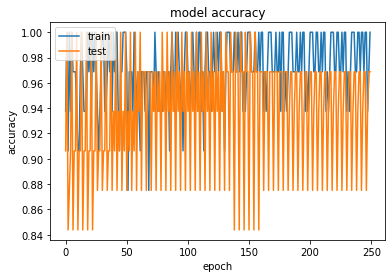

In [17]:
plt.plot(df.history['train_acc'])
plt.plot(df.history['test_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

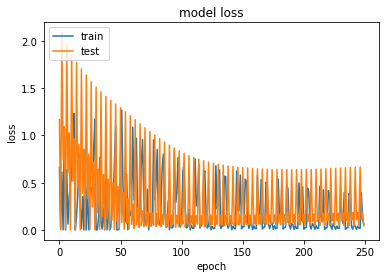

In [18]:
plt.plot(df.history['train_loss'])
plt.plot(df.history['test_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()